<a href="https://colab.research.google.com/github/Aishwarya-J05/dog-breed-classification/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip "/content/drive/MyDrive/Dog vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog vision/"

# End-to-end multi class dog breed classification 🐶

This notebook builds an end-to-end multiclass image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

## 2. Data
The data we are using is from Kaggle's dog breed ientification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview

## 4. Features
Some information about the data:
* We are dealing with images (unstructured data) so it probably best to use deeep learning  / transfer learning
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are arounfd 10,000+ images in training set (these images have labels)
* There are arounfd 10,000+ images in test set (these images don't have labels, because we want to predict them).

## Get our workspace ready
* Import TensorFlow 2.x
* Import TensorFlow Hub
* make sure we are using GPU

In [ ]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available !!!" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.19.0
TF Hub version: 0.16.1
GPU available !!!


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical so that's what we will be doing first, turning our images into tensors (numerical representations)


In [ ]:
# check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


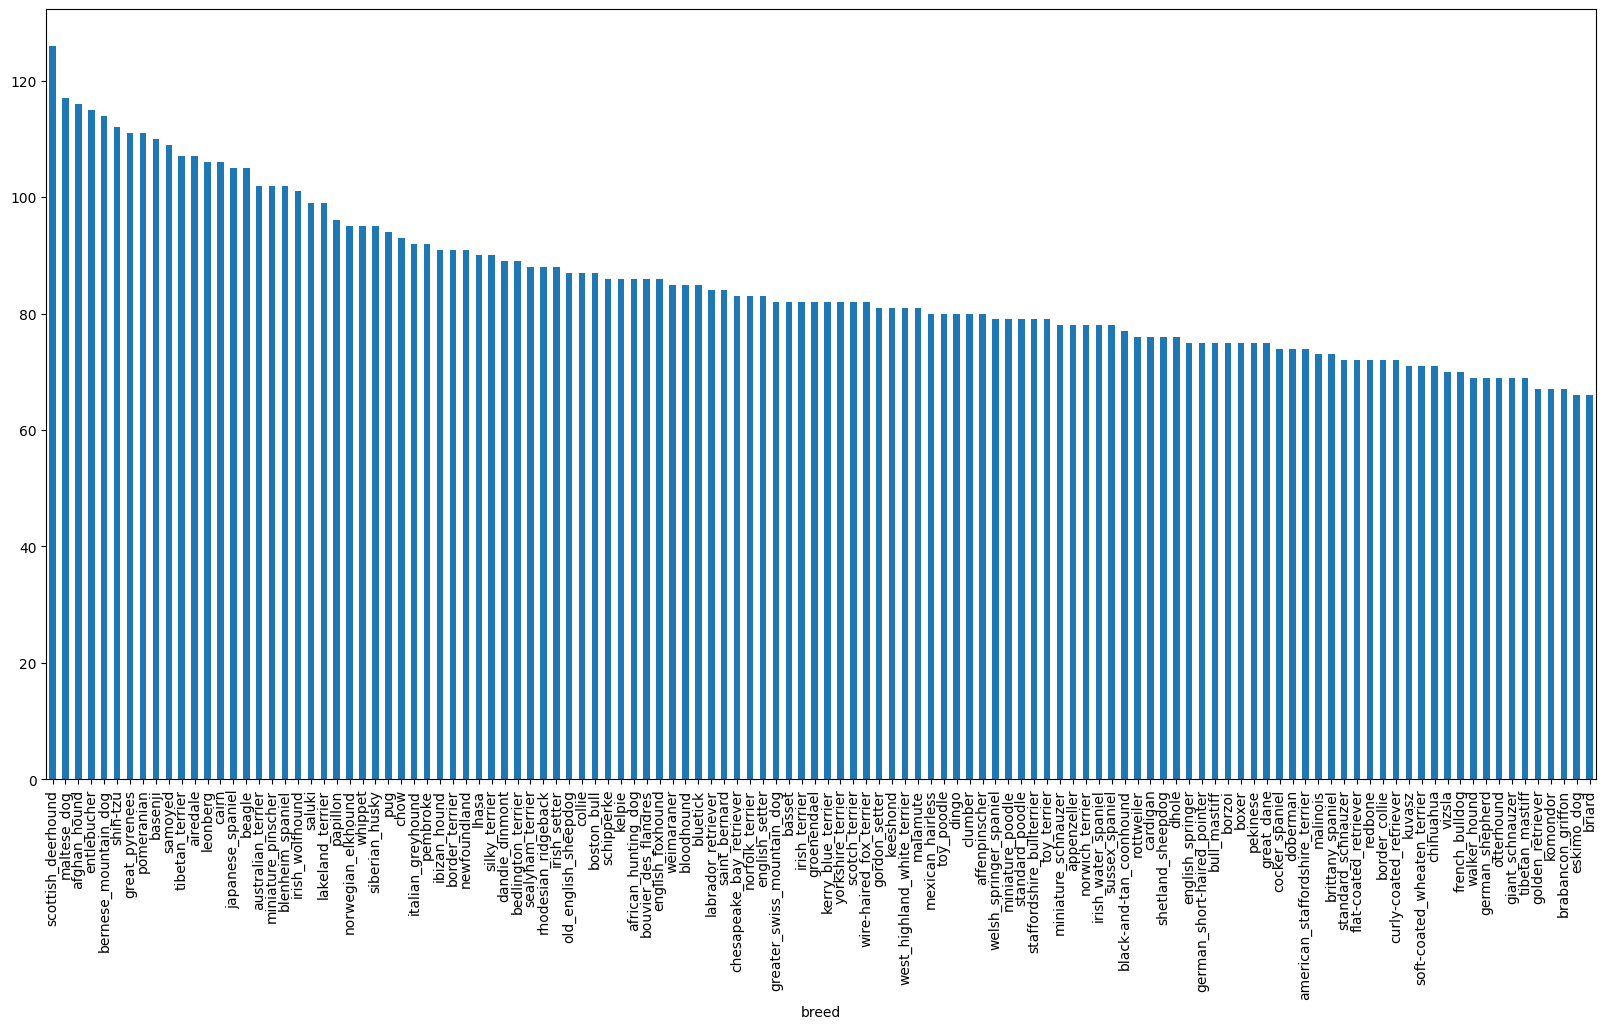

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

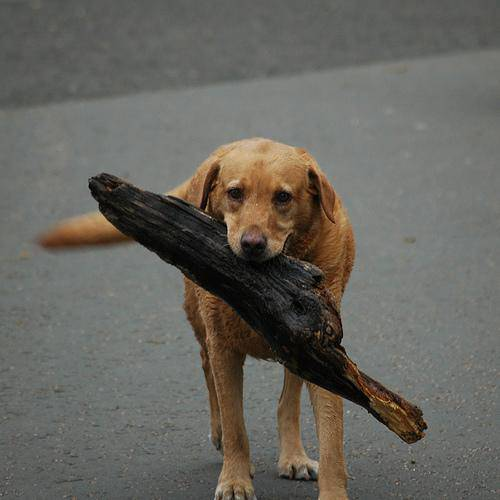

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels
Let's get a list of all our image file path names.

In [ ]:
# create a pathname from image ID's
filenames = [fname for fname in labels_csv["id"]]
filenames[:5]

['000bec180eb18c7604dcecc8fe0dba07',
 '001513dfcb2ffafc82cccf4d8bbaba97',
 '001cdf01b096e06d78e9e5112d419397',
 '00214f311d5d2247d5dfe4fe24b2303d',
 '0021f9ceb3235effd7fcde7f7538ed62']

In [ ]:
# pathnames
filenames = ["drive/MyDrive/Dog vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# check whether the number of filenames will match the number of image files
import os
if len(os.listdir("drive/MyDrive/Dog vision/train/")) == len(filenames):
  print("Filenames match with number of images")
else:
  print("Filenames do not match with number of images, check the target directory")

Filenames match with number of images


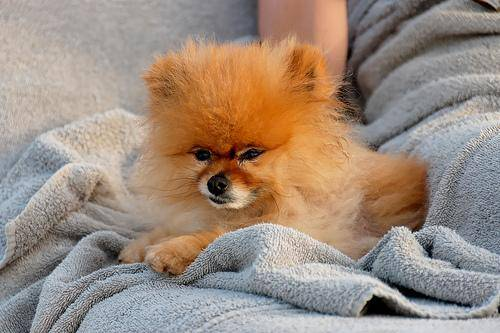

In [ ]:
# one more check
Image(filenames[8000])

In [ ]:
labels_csv['breed'][8000], labels_csv["id"][8000]

('pomeranian', 'c81778e436da96e7a89d9ef84b367525')

### Since we got our training image file paths in a list, let's prepare our labels

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()

# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[5])
print(boolean_labels[5].astype(int))

bedlington_terrier
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set


In [ ]:
# setup x and y variables
x = filenames
y = boolean_labels

 We are going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size=0.2,
                                                   random_state=42)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
x_train[:5], y_train[:2]

(['drive/MyDrive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessiong images (turning images into tensors)

To preprocess your images into tensors we are going to write a function which does a few things:
1. Take an image filepath as an input
2. Use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modefied `image`

In [ ]:
# convert an image into numpy array
from matplotlib.pyplot import imread
image =  imread(filenames[50])
image.shape

(240, 320, 3)

In [ ]:
image, image.max(), image.min()

(array([[[176, 163, 146],
         [157, 144, 127],
         [148, 135, 118],
         ...,
         [109,  94,  97],
         [ 76,  60,  70],
         [ 75,  59,  70]],
 
        [[168, 155, 138],
         [148, 135, 118],
         [150, 137, 120],
         ...,
         [100,  86,  86],
         [ 64,  49,  56],
         [ 86,  70,  80]],
 
        [[149, 133, 117],
         [128, 112,  96],
         [144, 131, 114],
         ...,
         [108,  94,  93],
         [ 73,  57,  60],
         [ 67,  50,  56]],
 
        ...,
 
        [[ 92,  75,  65],
         [ 87,  70,  60],
         [ 76,  62,  53],
         ...,
         [253, 241, 217],
         [255, 241, 220],
         [255, 243, 222]],
 
        [[ 89,  72,  62],
         [ 86,  69,  59],
         [ 77,  63,  52],
         ...,
         [252, 241, 221],
         [251, 238, 221],
         [249, 236, 219]],
 
        [[ 85,  68,  58],
         [ 87,  70,  60],
         [ 83,  69,  58],
         ...,
         [255, 245, 227],
  

In [ ]:
# turn image into tensors
tf.constant(image)[:3]

<tf.Tensor: shape=(3, 320, 3), dtype=uint8, numpy=
array([[[176, 163, 146],
        [157, 144, 127],
        [148, 135, 118],
        ...,
        [109,  94,  97],
        [ 76,  60,  70],
        [ 75,  59,  70]],

       [[168, 155, 138],
        [148, 135, 118],
        [150, 137, 120],
        ...,
        [100,  86,  86],
        [ 64,  49,  56],
        [ 86,  70,  80]],

       [[149, 133, 117],
        [128, 112,  96],
        [144, 131, 114],
        ...,
        [108,  94,  93],
        [ 73,  57,  60],
        [ 67,  50,  56]]], dtype=uint8)>

### Let's make a function to preprocess the image

In [ ]:
# define image size
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """ Text an image file path and turns the image into a Tensors"""
  # read in an image file
  image = tf.io.read_file(image_path)
  # turn the jpg images into numerical tensorsbwith 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert  the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image =  tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning data into batches

Why to turn data into batches ?

Let's say if we are trying to process 10,000+ images in one go, they all might not fit into a memory.

So that's why we do about 32 (batch size) images at a time (you can manually adjust batch size if needed).

In order to use tensorflow effectively we need our data in this form of tensor tuples which look like this:
`(image, label)`

In [ ]:
# create a simple functon to return tuple (image, label)
def get_image_label(image_path, label):
  """ Text an image file path name and the associated label, Process the image and returns a couple of (image, label)"""
  image = process_image(image_path)
  return image, label

In [ ]:
# demo of the above
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Let's write a function to turn all of our data x and y into batches.

In [ ]:
# Define the batch size (32)
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test data set, we probably don't have labels
  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only file paths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid data set, we don't need to shiver it
  elif valid_data:
    print("Creating validation data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # Training data batches
  else:
    print("Creating training data batches")
    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the tarining data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches
Creating validation data batches


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualising data batches

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing  images in a data batch
def show_25_images(image, label):
  """Displays a plot of 25 images and their labels from a data batch"""
  # setup the figure
  plt.figure(figsize=(10,10))
  # loop through  25 (for displaying 25 images)
  for i in range(25):
    # create a subplots (5 rows, 5 columns)
    ax =plt.subplot(5,5, i+1)
    # display an image
    plt.imshow(image[i])
    # add the image label as the title
    plt.title(unique_breeds[label[i].argmax()])
    # turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.535618  , 0.74337363, 0.62052697],
          [0.53166145, 0.7197217 , 0.594958  ],
          [0.484085  , 0.6466888 , 0.5304698 ],
          ...,
          [0.24477416, 0.17657681, 0.09793302],
          [0.25448263, 0.1923328 , 0.0885862 ],
          [0.2825368 , 0.22371331, 0.1099878 ]],
 
         [[0.4653099 , 0.6177696 , 0.5042192 ],
          [0.4297598 , 0.5722644 , 0.46200317],
          [0.33814773, 0.46622378, 0.3607878 ],
          ...,
          [0.26687497, 0.18479688, 0.10137434],
          [0.26393566, 0.20182295, 0.09796498],
          [0.2784314 , 0.21960786, 0.10588236]],
 
         [[0.26778948, 0.33728352, 0.25268093],
          [0.26169828, 0.3340985 , 0.24680857],
          [0.2307746 , 0.30050796, 0.21455146],
          ...,
          [0.28758463, 0.19678165, 0.09697423],
          [0.25856102, 0.2001454 , 0.0864199 ],
          [0.27677584, 0.22063965, 0.10691413]],
 
         ...,
 
         [[0.44185022, 0.15866819, 0.06226861],
          [0.43732

In [ ]:
len(train_images), len(train_labels)

(32, 32)

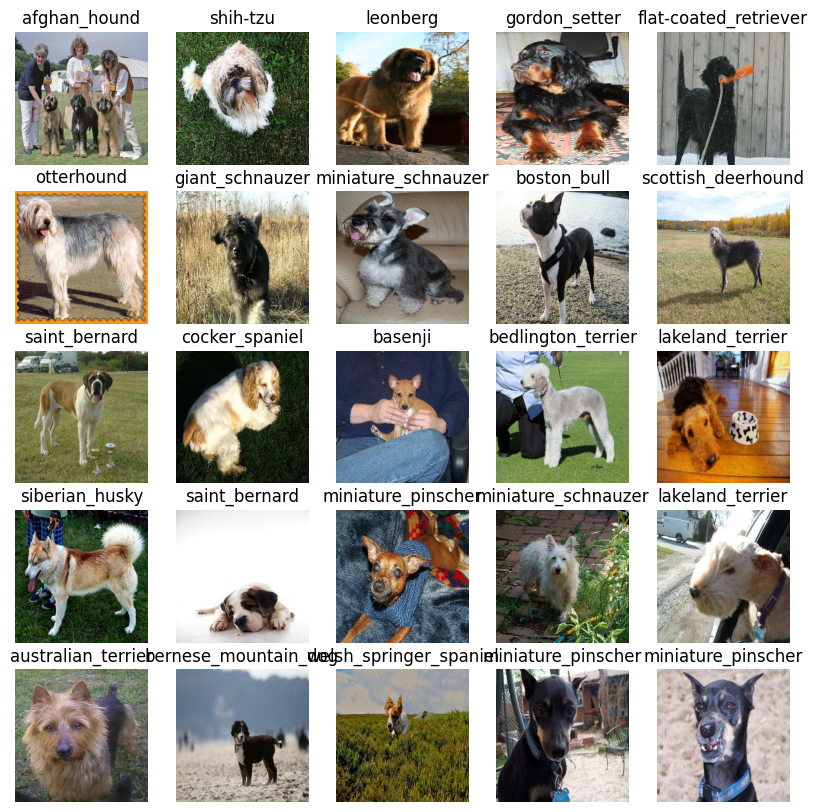

In [ ]:
# visualize the data in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

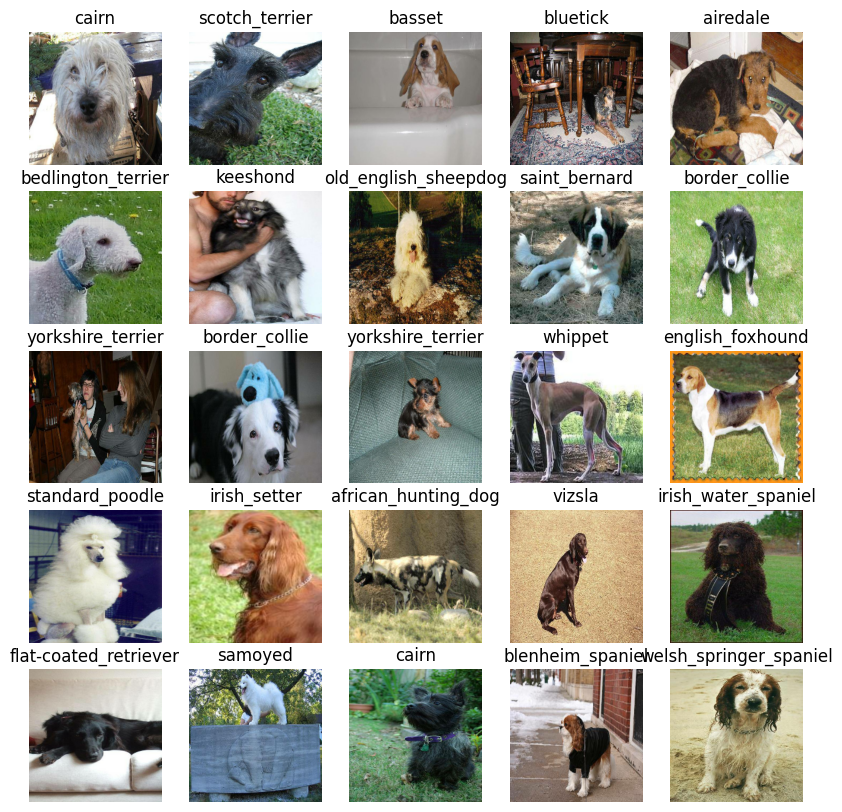

In [ ]:
# visualize the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a modal, there are few things we need to define :
* The input shape (our images shape, in the form of tensors) to our model
* The output shape (image labels, in the form of tensors) of our model
* The URL of the model we want to use from TensorFLow Hub
https://www.tensorflow.org/hub

In [ ]:
IMG_SIZE, len(unique_breeds)

(224, 120)

In [ ]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
*  Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# create a function which builds Keras model
def craete_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with : ", MODEL_URL)
